In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sunpy.coordinates import frames
import sunpy.map
from astropy.coordinates import SkyCoord
from astropy import units as u 
import datetime
import numpy as np 
from matplotlib.colors import LogNorm
import seaborn as sns
import scipy.stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
flare_list = pd.read_csv("flare_list_w_fwhm.csv")
flare_list = pd.read_csv("test_fwhm.csv")

flare_list["event_starttime"] = pd.to_datetime(flare_list["event_starttime"])

In [3]:
flare_list["goes_class_ind"].value_counts()

M    748
X     49
Name: goes_class_ind, dtype: int64

In [4]:
hpc_coords = SkyCoord(flare_list["hpc_x"]*u.arcsec, flare_list["hpc_y"]*u.arcsec, 
                      frame=frames.Helioprojective, obstime=flare_list["event_starttime"], 
                      observer="earth")

hcr_coords = hpc_coords.transform_to(frames.Heliocentric)
phi = hcr_coords.cylindrical.phi.wrap_at(360*u.deg).value

flare_list["phi"] = phi-90


flare_list.loc[(flare_list.phi < 0),'phi']=flare_list.phi+360

In [5]:
cme_list = pd.read_csv("/Users/laurahayes/ml_project_flares/flare_analysis/cme_lists/final_cme_list_2010_2018.csv")
cme_list["start_time_c2"] = pd.to_datetime(cme_list.date + cme_list.time, format="%Y/%m/%d%H:%M:%S") 

def get_times(x):
    xx = x.split()
    if len(xx)==3:
        return pd.to_datetime(" ".join(xx[1:]))
    else:
        return np.nan

cme_list["onset_times1"] = cme_list.onset_times1.map(get_times)
cme_list["onset_times2"] = cme_list.onset_times2.map(get_times)

In [6]:
cme_list = cme_list[cme_list["quality_val"] >1]

In [7]:
flare_interest = flare_list#[flare_list["goes_class_val"]>=5e-6]

In [8]:
def find_cme(flare_list, i):
    """
    Function to find is there is an associated CME for a particular flare
    
    Parameters
    ----------
    flare_list : pd.DataFrame
        flare list to search from
    i : ~int
        index of flare_list row to search for
        
    Returns
    -------
    yes/no : `str` 
        if there is an associated eruption
    positional angle difference : `float`
        absolute value of difference in angle between flare/CME
    quality : `int`
        quality index of eruptive event
    """
    
    
    # check its within 3 hours of flare
    cme_list_compare = cme_list[(cme_list["start_time_c2"]>=flare_list.iloc[i]["event_starttime"]\
                                 -datetime.timedelta(minutes=5)) &
                                (cme_list["start_time_c2"]<=flare_list.iloc[i]["event_starttime"]\
                                 +datetime.timedelta(hours=2))]
    
    # make sure the position locations make sense - absolute value <45 degrees between two
    cme_list_compare = cme_list_compare[np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi)<=90]

    # checks outputs and returns values if CMEs available
    if len(cme_list_compare)==0:
        return "no", np.nan, 0
    
    elif len(cme_list_compare)==1:
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]
    
    else:
#         print("more that one! {:d} has {:d} CMEs".format(i, len(cme_list_compare)))
#         print(cme_list_compare.quality_val.values, np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values)
        return "yes", np.abs(cme_list_compare.MPA - flare_list.iloc[i].phi).values[0], cme_list_compare.quality_val.values[0]

    




In [9]:
find_cme(flare_interest, 0)

('no', nan, 0)

In [10]:
cmes = []; angle_list = []; qual = []
for i in range(len(flare_interest)):
    cme, ang, q = find_cme(flare_interest, i)
    cmes.append(cme)
    angle_list.append(ang)
    qual.append(q)
    
flare_interest["cmes"] = cmes
flare_interest["angles"] = angle_list
flare_interest["qual"] = qual

In [11]:
flare_x = flare_interest[flare_interest["goes_class_ind"].isin(["X"])]
flare_m = flare_interest[flare_interest["goes_class_ind"].isin(["M"])]
flare_c = flare_interest[flare_interest["goes_class_ind"].isin(["C"])]


print("X \n",100*flare_x["cmes"].value_counts()/len(flare_x))
print("M \n",100*flare_m["cmes"].value_counts()/len(flare_m))
print("C \n",100*flare_c["cmes"].value_counts()/len(flare_c))

X 
 yes    73.469388
no     26.530612
Name: cmes, dtype: float64
M 
 no     65.106952
yes    34.893048
Name: cmes, dtype: float64
C 
 Series([], Name: cmes, dtype: float64)


In [12]:
flare_interest[flare_interest["event_starttime"]>"2013-11-08 02:00"][["event_starttime", "cmes", "goes_class", "qual"]]

,event_starttime,cmes,goes_class,qual
364,2013-11-08 04:20:00,no,X1.1,0
365,2013-11-08 09:22:00,no,M2.3,0
366,2013-11-10 05:08:00,yes,X1.1,2
367,2013-11-11 11:01:00,no,M2.4,0
368,2013-11-13 14:57:00,yes,M1.4,3
...,...,...,...,...
792,2017-09-09 04:14:00,yes,M1.1,2
793,2017-09-09 10:50:00,no,M3.7,0
794,2017-09-09 22:04:00,yes,M1.1,5
795,2017-09-10 15:35:00,yes,X8.2,5


In [13]:
flare_x[["event_starttime", "cmes", "goes_class", "qual"]]

,event_starttime,cmes,goes_class,qual
27,2011-02-15 01:44:00,yes,X2.2,3
52,2011-03-09 23:13:00,no,X1.5,0
76,2011-08-09 07:48:00,yes,X6.9,3
81,2011-09-06 22:12:00,yes,X2.1,2
82,2011-09-07 22:32:00,yes,X1.8,2
89,2011-09-22 10:29:00,yes,X1.4,5
93,2011-09-24 09:21:00,yes,X1.9,2
122,2011-11-03 20:16:00,no,X1.9,0
147,2012-01-27 17:37:00,yes,X1.7,5
151,2012-03-05 02:30:00,yes,X1.1,3


In [14]:
flare_interest.keys()

Index(['event_starttime', 'event_peaktime', 'event_endtime', 'goes_class_ind',
       'goes_class', 'goes_class_val', 'integrated_flux', 'noaa_ar',
       'position_hgs', 'hgs_lat', 'hgs_lon', 'hpc_x', 'hpc_y', 'tt',
       'matchtime', 'fwhm', 'dur_full', 'fwhm_start', 'fwhm_end', 'fwhm_rise',
       'fwhm_decay', 'fwhm_dur', 'phi', 'cmes', 'angles', 'qual'],
      dtype='object')

In [15]:
flare_cmes = flare_interest[(flare_interest.qual>=2)]; print(len(flare_cmes))
flare_nocmes = flare_interest[(flare_interest.qual<2)]; print(len(flare_nocmes))

297
500


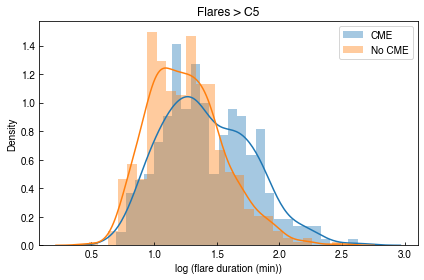

In [16]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.dur_full/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.dur_full/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare duration (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()



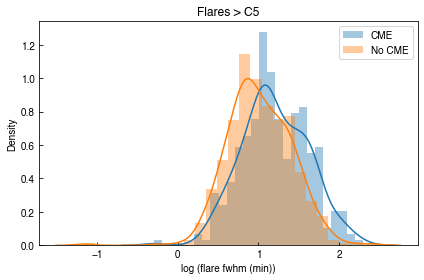

In [17]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.fwhm/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.fwhm/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare fwhm (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()




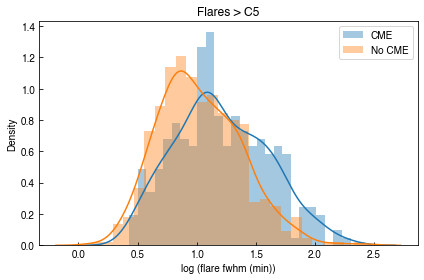

In [18]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.fwhm_dur/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.fwhm_dur/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare fwhm (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()



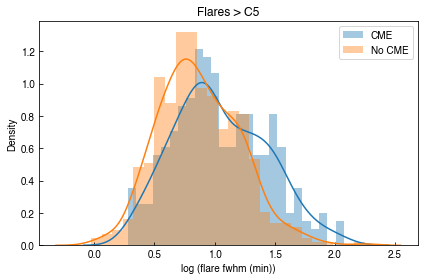

In [19]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.fwhm_decay/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.fwhm_decay/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare fwhm (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()

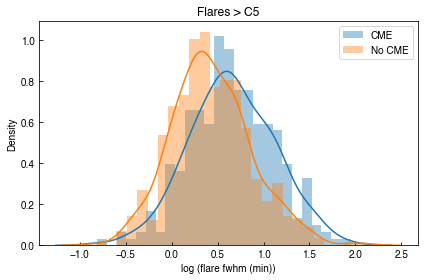

In [20]:
plt.rcParams['font.family'] = 'Helvetica'
sns.distplot(np.log10(flare_cmes.fwhm_rise/60), bins=26, label="CME", )
sns.distplot(np.log10(flare_nocmes.fwhm_rise/60), bins=26, label="No CME")
plt.legend()
plt.xlabel("log (flare fwhm (min))")
plt.title("Flares > C5")
ax = plt.gca()
ax.tick_params(which="both", direction="in")
plt.tight_layout()

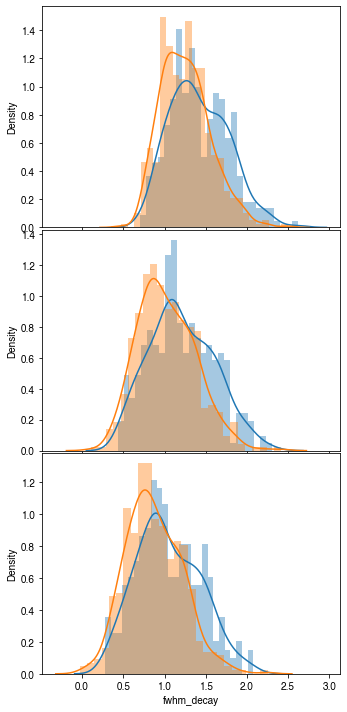

In [21]:
fig, ax = plt.subplots(3, sharex=True, figsize=(5, 10))
sns.distplot(np.log10(flare_cmes.dur_full/60), bins=26, label="CME", ax=ax[0])
sns.distplot(np.log10(flare_nocmes.dur_full/60), bins=26, label="No CME", ax=ax[0])

sns.distplot(np.log10(flare_cmes.fwhm_dur/60), bins=26, label="CME", ax=ax[1])
sns.distplot(np.log10(flare_nocmes.fwhm_dur/60), bins=26, label="No CME", ax=ax[1])

sns.distplot(np.log10(flare_cmes.fwhm_decay/60), bins=26, label="CME", ax=ax[2])
sns.distplot(np.log10(flare_nocmes.fwhm_decay/60), bins=26, label="No CME", ax=ax[2])

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

In [22]:
sns.distplot(np.log10(flare_cmes.decay_jeff/60),  label="CME")
sns.distplot(np.log10(flare_nocmes.decay_jeff/60),  label="No CME")



AttributeError: 'DataFrame' object has no attribute 'decay_jeff'

In [23]:
print("Jeff decay times:")
print(np.mean(flare_nocmes.decay_jeff), np.mean(flare_cmes.decay_jeff))
print(10**(np.mean(np.log10(flare_nocmes.decay_jeff))), 10**(np.mean(np.log10(flare_cmes.decay_jeff))))

Jeff decay times:


AttributeError: 'DataFrame' object has no attribute 'decay_jeff'

In [24]:
print("Jeff duration times:")
print(np.mean(flare_nocmes.dur_jeff), np.mean(flare_cmes.dur_jeff))
print(10**(np.mean(np.log10(flare_nocmes.dur_jeff))), 10**(np.mean(np.log10(flare_cmes.dur_jeff))))

Jeff duration times:


AttributeError: 'DataFrame' object has no attribute 'dur_jeff'

In [25]:
print("Full duration times:")
print(np.mean(flare_nocmes.dur_full), np.mean(flare_cmes.dur_full))
print(10**(np.mean(np.log10(flare_nocmes.dur_full))), 10**(np.mean(np.log10(flare_cmes.dur_full))))

Full duration times:
1424.52 2254.5454545454545
1081.0935934639213 1571.26825354295


In [ ]:
flare_list.de